In [3]:
## Import required libraries

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import random

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import pathlib
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder


%matplotlib inline

In [4]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'C:/datasets/TensorFlow/workspace/training_demo/annotations/simple_label_index.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [5]:
# Define function for plotting images and detection boxes

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 12),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.75) # Requires 75% confidence to show an image
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations )

In [6]:
# Reads tfrecords for training
filenames = 'C:/datasets/TensorFlow/workspace/training_demo/tfrecords/train/F1-Car.tfrecord'
raw_dataset = tf.data.TFRecordDataset(filenames)

raw_image_dataset = raw_dataset


# Create a dictionary describing the features.
image_feature_description = {
      'image/height': tf.io.FixedLenFeature([], tf.int64),
     'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/encoded': tf.io.FixedLenFeature([], tf.string),
#      'image/format': tf.io.FixedLenFeature([], tf.string),
     'image/filename': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/width': tf.io.FixedLenFeature([], tf.int64),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image/object/bbox/xmax: (None,), image/object/bbox/xmin: (None,), image/object/bbox/ymax: (None,), image/object/bbox/ymin: (None,), image/object/class/label: (None,), image/object/class/text: (None,), image/encoded: (), image/filename: (), image/height: (), image/width: ()}, types: {image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/object/class/label: tf.int64, image/object/class/text: tf.string, image/encoded: tf.string, image/filename: tf.string, image/height: tf.int64, image/width: tf.int64}>

In [7]:
gt_boxes = []

train_images_np = []

# Translate extracted features to numpy arrays
for img in parsed_image_dataset:
    label_num = len(img['image/object/bbox/ymin'].values.numpy())
    for x in range(label_num):
        box = np.array([[img['image/object/bbox/ymin'].values.numpy()[x], img['image/object/bbox/xmin'].values.numpy()[x], img['image/object/bbox/ymax'].values.numpy()[x], img['image/object/bbox/xmax'].values.numpy()[x]]])
        gt_boxes.append(box)
        img_tensor = tf.io.decode_image(
        img['image/encoded'].numpy(), channels=None, dtype=tf.dtypes.uint8, name=None, expand_animations=True).numpy()
        train_images_np.append(img_tensor)

In [8]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
num_classes = 1

category_index = category_index
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


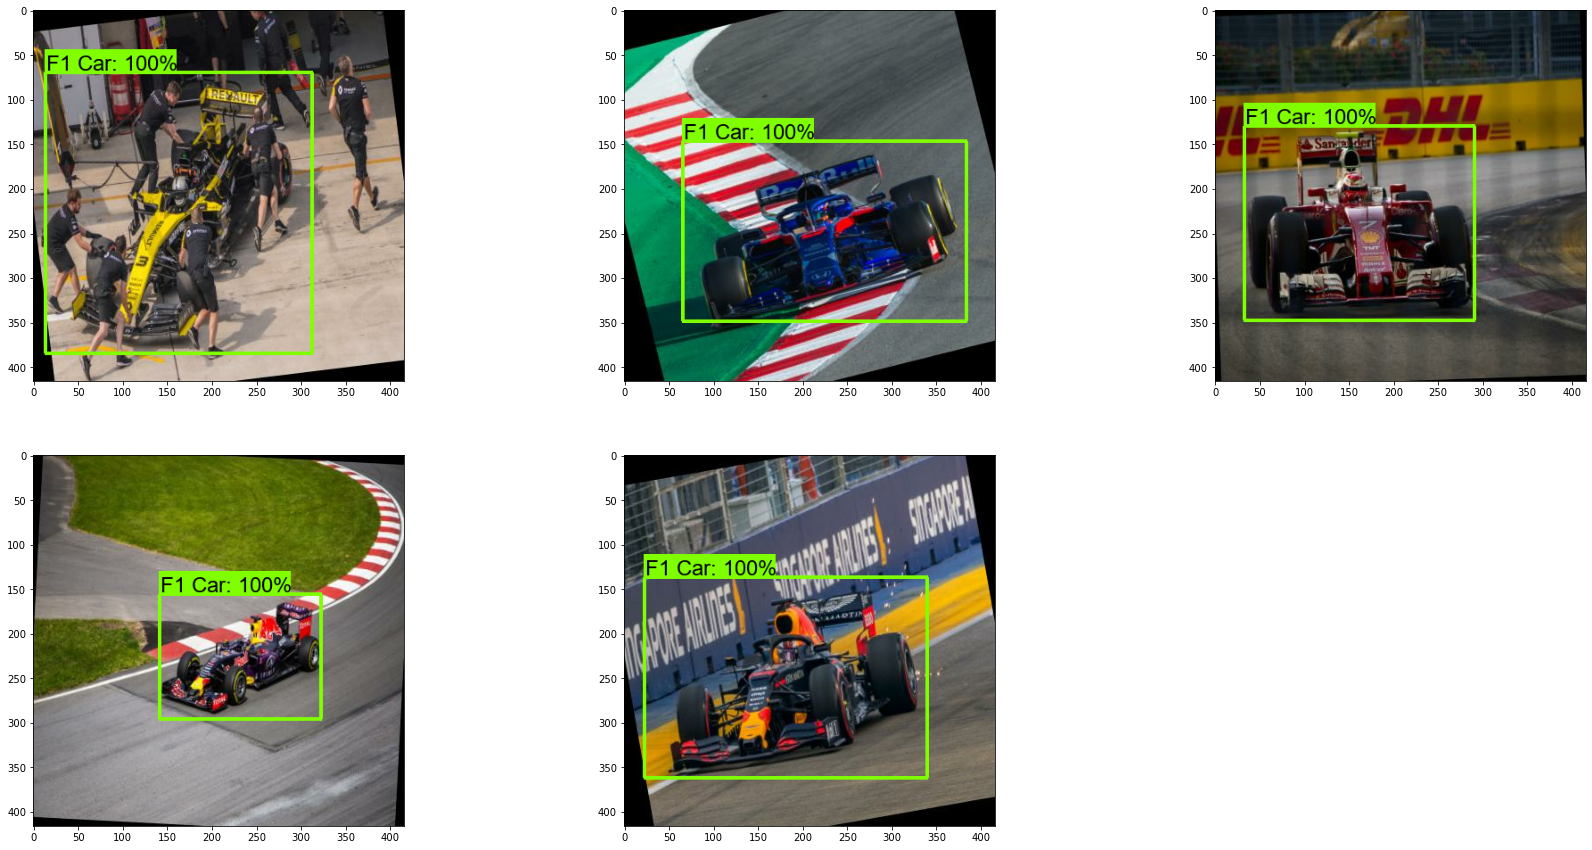

In [9]:
# Ensure boxes are being plotted accurately

dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

In [10]:
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils

# Loads the existing model

tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'C:/datasets/TensorFlow/workspace/training_demo/models/my_ssd_resnet50_v1_fpn/pipeline.config'
checkpoint_path = 'C:/datasets/TensorFlow/workspace/training_demo/pre-trained-models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.

# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 416, 416, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


In [11]:
import datetime
from tensorflow.keras import mixed_precision

train_log_dir = 'C:/datasets/TensorFlow/workspace//training_demo/Tensorboard/logs'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)

tf.keras.backend.set_learning_phase(True)

train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

# These Hyper parameters to tune
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 150
momentum = 0.7

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 416x416.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[416, 416, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
    
#   with train_summary_writer.as_default():
#       tf.summary.scalar('loss', total_loss.result(), step=idx)
#       #tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  if idx % 10 == 0:
    now = datetime.datetime.now().strftime("%H:%M:%S")
    print(str(now) + ' batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)
    
print('Done fine-tuning!')

Start fine-tuning!


C:\ProgramData\Anaconda3\envs\pytorch3\lib\site-packages\tensorflow\python\keras\backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


18:32:34 batch 0 of 150, loss=1.464682
18:32:36 batch 10 of 150, loss=0.6213466
18:32:38 batch 20 of 150, loss=0.36745945
18:32:41 batch 30 of 150, loss=1.0476648
18:32:43 batch 40 of 150, loss=0.59592617
18:32:45 batch 50 of 150, loss=0.5532577
18:32:48 batch 60 of 150, loss=0.58686364
18:32:50 batch 70 of 150, loss=0.3636775
18:32:52 batch 80 of 150, loss=0.3403215
18:32:55 batch 90 of 150, loss=0.5322589
18:32:57 batch 100 of 150, loss=0.6061275
18:33:00 batch 110 of 150, loss=0.69550794
18:33:02 batch 120 of 150, loss=0.4289838
18:33:04 batch 130 of 150, loss=0.22384845
18:33:07 batch 140 of 150, loss=0.4552762
Done fine-tuning!


In [12]:
# Make predictions by specifying the tfrecord location (validation dataset by default)

valid_filenames = 'C:/datasets/TensorFlow/workspace/training_demo/tfrecords/valid/F1-Car.tfrecord'
test_dataset = tf.data.TFRecordDataset(valid_filenames)

prediction_dir = 'C:/datasets/TensorFlow/workspace/training_demo/tfrecords/valid/predictions/'

# test_filenames = 'C:/datasets/TensorFlow/workspace/training_demo/tfrecords/test/F1-Car.tfrecord'
# test_dataset = tf.data.TFRecordDataset(test_filenames)

# test_image_dataset = test_dataset

test_image_dataset = test_dataset

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_test_image_dataset = test_image_dataset.map(_parse_image_function)

test_images_np = []

for img in parsed_test_image_dataset:
    image_raw = img['image/encoded'].numpy()
    img_tensor = tf.io.decode_image(
    image_raw, channels=None, dtype=tf.dtypes.uint8, name=None, expand_animations=True)
    img_tensor_exp = tf.expand_dims(img_tensor, axis=0).numpy()
    test_images_np.append(img_tensor_exp)
    
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

plt_detects = []

label_id_offset = 1
test_image_num = len(test_images_np)
for i in range(test_image_num):
    if i % 2 == 0:
        print(f'{i}/{test_image_num} predicted')
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(15, 20), image_name=f"{prediction_dir}prediction" + ('%02d' % i) + ".jpg")
    plt_detects.append(detections)

0/24 predicted
2/24 predicted
4/24 predicted
6/24 predicted
8/24 predicted
10/24 predicted
12/24 predicted
14/24 predicted
16/24 predicted
18/24 predicted
20/24 predicted
22/24 predicted


In [ ]:
for p in range(test_image_num):
    print(f'image {p} predicted with confidence', plt_detects[p]['detection_scores'].numpy().max()

In [129]:
# Amend threshhold for plot_detections to 0.5 for video tracking

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 12),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.5)
  x = plt.imshow(image_np_with_annotations)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [131]:
# This runs an initial pass through of the video to capture and create the tensors
# import the necessary packages
import numpy as np
import cv2

# Dictionary capturing the frames 
tracker = {}    

c = 0
    
cv2.startWindowThread()

video_location = 'C:/Users/alex_/Downloads/2017_Singapore_GP.mp4'

cap = cv2.VideoCapture(video_location)

# the output will be written to output.avi
out = cv2.VideoWriter(
    'output.avi',
    cv2.VideoWriter_fourcc(*'MJPG'),
    15.,
    (640,480))

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # resizing for faster detection
    frame = cv2.resize(frame, (640, 480)) 
    img_tensor = tf.convert_to_tensor(frame, dtype=tf.uint8)
    img_tensor_exp = tf.expand_dims(img_tensor, axis=0).numpy()
    input_tensor = tf.convert_to_tensor(img_tensor_exp, dtype=tf.float32)
    tracker[c] = [img_tensor, input_tensor]
    c = c+1

    # Write the output video 
    out.write(frame.astype('uint8'))
    # Display the resulting frame
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
# and release the output
out.release()
# finally, close the wqindow
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

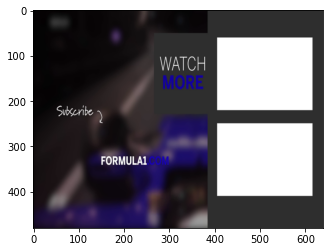

In [103]:
# where video predictions will be captured
prediction_dir = 'C:/datasets/TensorFlow/workspace/training_demo/video/predictions/'

# This creates the image predictions

for key, frame  in tracker.items():
    output_dict = detect(frame[1].numpy())
    plot_detections(frame[0].numpy(),
                        output_dict['detection_boxes'][0].numpy(),
                        output_dict['detection_classes'][0].numpy().astype(np.uint32)
                        + label_id_offset,
                        output_dict['detection_scores'][0].numpy(),
                        category_index, image_name=f'{prediction_dir}{key}_frame.jpeg')

In [128]:
import glob
 
img_array = []
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

for filename in sorted(glob.glob(f'{prediction_dir}*.jpeg') , key=numericalSort):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter(f'{prediction_dir}output_prediction.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()